# Sixth model (test improvements notebook)

This model will try to predict exam level labels for positive patients

## Imports

In [1]:
import numpy as np
from modules.balance import *
from modules.model import *
from torchsummary import summary

In [12]:
import torch
torch.cuda.empty_cache()

print(f'PyTorch version: {torch.__version__}')
print("GPU found :)" if torch.cuda.is_available() else "No GPU :(")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

PyTorch version: 1.7.1
GPU found :)


# Load dataset

In [13]:
dataset = torch.load('datasets/multi_image_multi_label_dataset.pt')
nb_images = 50

## CNN

In [14]:
class ModelV6(nn.Module):
    
    def __init__(self, input_channels=3*nb_images):
        """Convnet with 4 convolution layer + pooling + BN, with 3 fully connected at the end"""
        super().__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=256, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256, 512, 3)
        self.bn2 = nn.BatchNorm2d(512)
        self.conv3 = nn.Conv2d(512, 256, 3)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 64, 3)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64*14*14 , 512)
        self.fc2 = nn.Linear(512, 128)
        
        # Specific outputs layers
        self.fc_location1 = nn.Linear(128, 64)
        self.fc_location2 = nn.Linear(64, 3)
        self.fc_ratio1 = nn.Linear(128, 64)
        self.fc_ratio2 = nn.Linear(64, 2)
        self.fc_type1 = nn.Linear(128, 64)
        self.fc_type2 = nn.Linear(64, 3)
        
        self.dropout = nn.Dropout(0.5)
        
        # Output activations
        self.softmax = nn.LogSoftmax(dim=1)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 64*14*14) # Flatten
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        location_out = F.relu(self.fc_location1(x))
        location_out = self.sigmoid(self.fc_location2(location_out))
        
        ratio_out = F.relu(self.fc_ratio1(x))
        ratio_out = self.softmax(self.fc_ratio2(ratio_out))
        
        type_out = F.relu(self.fc_type1(x))
        type_out = self.softmax(self.fc_type2(type_out))
        
        return location_out, ratio_out, type_out

In [15]:
model = ModelV6().to(device)
summary(model, (150, 256, 256))

## Split data into train and test

In [16]:
batch_size = 1
ratio = 0.2

train_loader, test_loader = train_test_split(dataset, ratio, batch_size)

print(f'Train size: {len(train_loader)}')
print(f'Test size: {len(test_loader)}')

Train size: 72
Test size: 18


## Model Training

In [7]:
num_epoch = 50
step_count = len(train_loader)
MSE = nn.MSELoss()
NLL = nn.NLLLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)

losses = list()
losses_ratio = list()
losses_location = list()
losses_type = list()

save_filename = './models/model_v5.h5'

for epoch in range(num_epoch):
    
    epoch_loss = 0
    epoch_loss_ratio = 0
    epoch_loss_location = 0
    epoch_loss_type = 0
    
    for i, sample in enumerate(train_loader):
        
        images = sample['image'].to(device, dtype=torch.float)
        ratios = sample['ratios']
        locations = sample['locations']
        types = sample['types']
        
        optimizer.zero_grad()
        
        location_out, ratio_out, type_out = model(images)
        
        # Compute loss for each category of labels
        loss_ratio = NLL(ratio_out, ratios.to(device))
        loss_location = MSE(location_out, locations.to(device))
        loss_type = NLL(type_out, types.to(device))
        
        # Keep track of separate losses
        epoch_loss_ratio += loss_ratio
        epoch_loss_location += loss_location
        epoch_loss_type += loss_type

        loss = loss_ratio + loss_location + loss_type
        epoch_loss += loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        
        if ((i+1) % int(step_count/5) == 0):
            print(f"Epoch [{epoch + 1}/{num_epoch}]" f", step [{i + 1}/{step_count}]" f", loss: {loss.item():.4f}")
    
    losses.append(epoch_loss)
    losses_ratio.append(epoch_loss_ratio)
    losses_location.append(epoch_loss_location)
    losses_type.append(epoch_loss_type)

In [8]:
torch.save(model.state_dict(), './models/model_v6.h5')

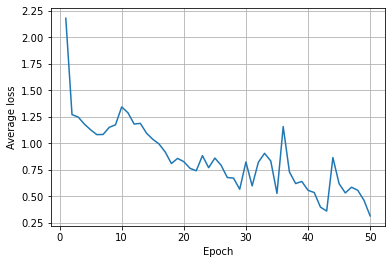

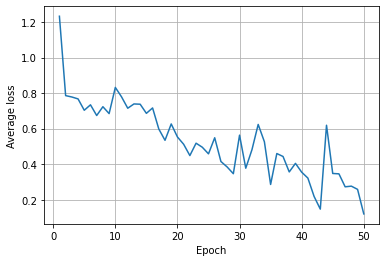

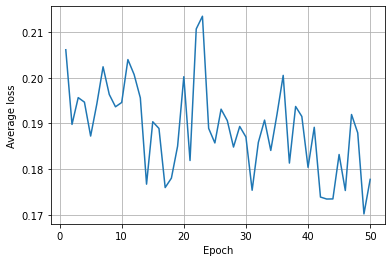

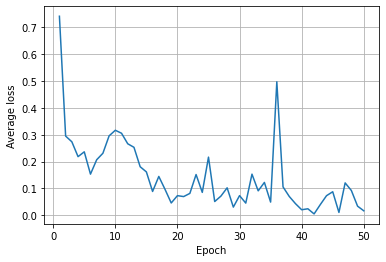

In [9]:
plot_loss(losses, num_epoch, len(train_loader), './figures/Global loss model v6 study level.png')
plot_loss(losses_ratio, num_epoch, len(train_loader), './figures/Ratio loss model v6 study level.png')
plot_loss(losses_location, num_epoch, len(train_loader), './figures/Location loss model v6 study level.png')
plot_loss(losses_type, num_epoch, len(train_loader), './figures/Type loss model v6 study level.png')

## Test the model

In [17]:
# Load model for evaluation
trained_model = ModelV6()
trained_model.load_state_dict(torch.load('./models/model_v6.h5'))
trained_model.to(device)

ModelV6(
  (conv1): Conv2d(150, 256, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc_location1): Linear(in_features=128, out_features=64, bias=True)
  (fc_location2): Linear(in_features=64, out_features=3, bias=True)
  (fc_ratio1): Linear(in_feature

In [25]:
correct_ratio = 0
correct_location = 0
correct_type = 0
correct = 0
total = 0
    
with torch.no_grad():
    for sample in test_loader:

        images = sample['image'].to(device, dtype=torch.float)
        ratios = sample['ratios'].to(device)
        locations = sample['locations'].to(device)
        types = sample['types'].to(device)
        
        location_out, ratio_out, type_out = trained_model(images)
        
        # Accuracy for ratios predictions
        _, pred_ratio = torch.max(ratio_out.data, 1)
        res_ratio = (pred_ratio == ratios).sum().item()
        correct_ratio += res_ratio
        
        # Accuracy for types predictions
        _, pred_type = torch.max(type_out.data, 1)
        res_type = (pred_type == types).sum().item()
        correct_type += res_type
    
        
        # Accuracy for locations predictions
        pred_location = torch.tensor([[0 if x < 0.5 else 1 for x in location_out[0]]]).to(device)
        res_location = (pred_location == locations).all().sum().item()
        correct_location += res_location
            
        # Global accuracy 
        corrects = res_ratio + res_location + res_type
        
        if corrects == 3: 
            correct += 1
            
        total += ratios.size(0)

In [26]:
print(f'Accuracy on {total} test patients for ratios prediction: {100 * correct_ratio / total:.2f}%')
print(f'Accuracy on {total} test patients for locations prediction: {100 * correct_location / total:.2f}%')
print(f'Accuracy on {total} test patients for types prediction: {100 * correct_type / total:.2f}%')
print(f'Global accuracy on {total} test patients: {100 * correct / total:.2f}%')

Accuracy on 18 test patients for ratios prediction: 72.22%
Accuracy on 18 test patients for locations prediction: 44.44%
Accuracy on 18 test patients for types prediction: 88.89%
Global accuracy on 18 test patients: 38.89%
